In [1]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from random import randint

# Continuous-time Markov chains with discrete state space

## Constructing a continuous-time Markov chain

Before exploring any properties of continuous-time Markov chains, we want to see how such a Markov chain can be constructed for a given rate matrix. We will consider the 3-state rate matrix $Q$ defined below.

In [2]:
# rate of moving from 0 to 1
q_01 = 8
# rate of moving from 0 to 2
q_02 = 1
# rate of moving from 1 to 0
q_10 = 1
# rate of moving from 1 to 2
q_12 = 1
# rate of moving from 2 to 0
q_20 = 5
# rate of moving from 2 to 1
q_21 = 5

Q = np.array([[- q_01 - q_02, q_01, q_02], [q_10, -q_10 - q_12, q_12], [q_20, q_21, -q_20 - q_21]])

# we round the matrix to avoid floating point errors
Q = np.round(Q,10)

print("Q = \n", Q)

Q = 
 [[ -9   8   1]
 [  1  -2   1]
 [  5   5 -10]]


As before, we define a function that checks whether a matrix satisfies all properties of a rate matrix.

In [3]:
#here we check whether the matrix is a rate matrix
def check_rate_mat(Q):
    if np.shape(Q)[1] != np.shape(Q)[0]:
        print("This is not a rate matrix, it is not square.")
        return
    elif False in (np.round(np.sum(Q, axis = 1),5) == 0):
        print("This is not a rate matrix, at least one row does not sum to 0.")
        return
    for i in range(0,np.shape(Q)[1]):
        for j in range(0,np.shape(Q)[1]):
            if (j != i) & (Q[i,j] < 0):
                print("This is not a rate matrix, the transition rate from " 
                      + str(i) + " to " + str(j) + " is negative.")
                return

If the matrix we defined is a rate matrix, the following cell should not lead to any output.

In [4]:
check_rate_mat(Q)

Recall that we can construct a continuous Markov chain in two steps: 
- first we construct the skeleton, jump or routing chain, i.e. the discrete chain that only records where the chain moves, and not how long it stays in each state
- then we sample the exponential waiting times with rates corresponding to the total rate at which we leave each state in the routing chain.

See also page 150 in Durrett for a more detailed explanation of this process.


### The routing chain 

Let us first find the routing matrix $R$ corresponding to our rate matrix $Q$. The entries of $R$ the probabilities that we move from $i$ to $j$ given that we leave $i$, i.e. $R_{i,j} = \frac{Q_{i,j}}{-Q_{i,i}}$ for $i \neq j$.

In [5]:
# this function computes the routing matrix
# given a rate matrix Q

def route_from_rate(Q):
    
    check_rate_mat(Q)
    
    R = np.zeros(np.shape(Q))
    s = np.shape(Q)[1]
    
    for i in range(0,s-1):
        if Q[i,i] == 0:
            R[i,i] = 1
        else:
            for j in range(0,s-1):
                if j != i:
                    R[i,j] = np.round(Q[i,j]/-Q[i,i],9)
            R[i,s-1] = 1 - sum(R[i,:])
            
    if Q[s-1,s-1] == 0:
        R[s-1,s-1] = 1
    else:
        for j in range(0,s-2):
            R[s-1,j] = np.round(Q[s-1,j]/-Q[s-1,s-1],9)
        R[s-1,s-2] = 1 - sum(R[s-1,:])
                                          
    return R


Let us apply this function on our rate matrix $Q$ to get the routing matrix $R$.

In [6]:
R = route_from_rate(Q)
print("R = \n" + str(R))

R = 
[[0.         0.88888889 0.11111111]
 [0.5        0.         0.5       ]
 [0.5        0.5        0.        ]]


To make sure that we always have a stochastic matrix we again define the function that test this for us.

In [7]:
#here we check whether the matrix is a probability matrix
def check_trans(P):
    if np.shape(P)[1] != np.shape(P)[0]:
        print("This is not a proper transition matrix, it is not square.")
        return
    elif True in (P < 0):
        print("This is not a proper transition matrix, at least one entry is negative.")
        return
    elif False in ( np.sum(P, axis = 1) == 1):
        print("This is not a proper transition matrix, at least one row does not sum to 1.")
        return

In [8]:
check_trans(R)

Let us now contruct the discrete time chain $X$ that will give us the path that the continuous Markov chain will follow. Here we sample the chain first and then plot it, rather than doing this all at once like in earlier notebooks.

In [9]:
# this function samples a path of a Markov chain with 
# transition matrix: P
# starting state: start
# number of discrete steps: nsteps

def sample_path(P, start, nsteps):
    
    #first we check whether we have a valid transition matrix
    check_trans(P)
    
    # second we check whether start is a valid state of this Markov chain
    if start not in range(0,np.shape(P)[1]):
        print("This is not a valid starting point.")
        return

    # we will use this to save the states
    X = np.zeros(nsteps+1)
    # starting state
    X[0] = start
    for i in range(0, nsteps) :
        step = uniform.rvs(size = 1, loc = 0, scale = 1)
        next = 0
        while sum(P[int(X[i])][range(0,next+1)]) < step:
                  next = next + 1
        X[i+1] = next
        
    X = X.astype(int)
    return X

Below you can see the first states of a sample path for our routing matrix $R$.

In [10]:
# number of steps
steps = 10
# initial state
start = 0

X = sample_path(R, start, steps)
print("X = " + str(X))

X = [0 1 2 1 2 0 1 2 1 0 1]


We now define a function that plots this path.

In [11]:
# Plots the path of a sequence X

def plot_path(X):
    
    plt.figure(figsize=(17, 4))  
    # Remove the plot frame lines.
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)    

    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    #Label axes and put in ticks
    plt.ylabel('State')
    plt.xlabel('Time')
    plt.axis([-1, len(X), -0.2, max(X)+0.2])
    plt.xticks(np.arange(0, len(X), step=max(1,np.floor(len(X)/20))));
    plt.yticks(np.arange(0, max(X)+1, step = 1));    
    
    # Choose style of the lines
    ax.plot(X, linestyle = 'dotted', marker = 's', color = 'firebrick')
    return

Below you can see the plot of the path of the routing chain we just sampled.

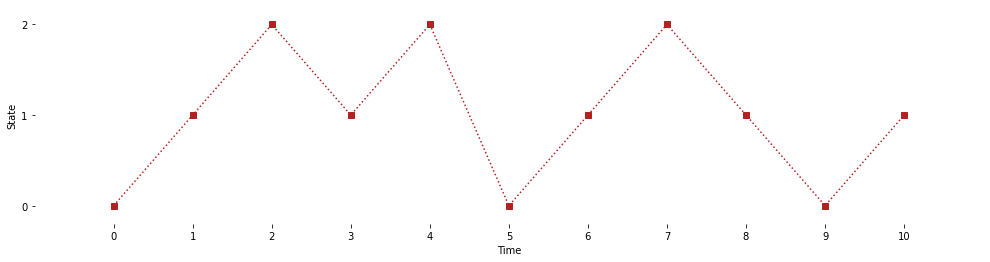

In [12]:
plot_path(X)

The path above is how we used to visualize our discrete Markov chains, but you will see later that the connection between the discrete routing chain and the continuous chain will be more visible if we consider the chain to stay in each state for a unit time before it jumps again. For this reason we will visualize the sample paths in that way today.

In [13]:
# plots a sequence X with unit holding times

def plot_path_step(X):
    
    s = len(X)
    # g determines at how many times we evaluate X(t)
    g = s*1000
    # these are the times at which we evaluate X(t)
    x = np.linspace(0, s, g+1, endpoint = False)
    # Z is used to record the continuous version of the discrete chain,
    # i.e. the version that stays in each state for one time unit
    Z = np.zeros(len(x))
    for i in range(0,len(x)):
        Z[i] = X[int(np.floor(x[i]))]
        
    
    plt.figure(figsize=(17, 4))  
    # Remove the plot frame lines.
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)    

    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    #Label axes and put in ticks
    plt.ylabel('State')
    plt.xlabel('Time')
    plt.axis([-1, len(X), -0.2, max(X)+0.2])
    plt.xticks(np.arange(0, len(X), step=max(1,np.floor(len(X)/20))));
    plt.yticks(np.arange(0, max(X)+1, step = 1));    
    
    # Choose style of the lines
    ax.plot(x, Z, linestyle = 'solid', color = 'firebrick')
    return

Below you see a plot of the same sample path, except that we now consider the chain to stay in each state for one unit time.

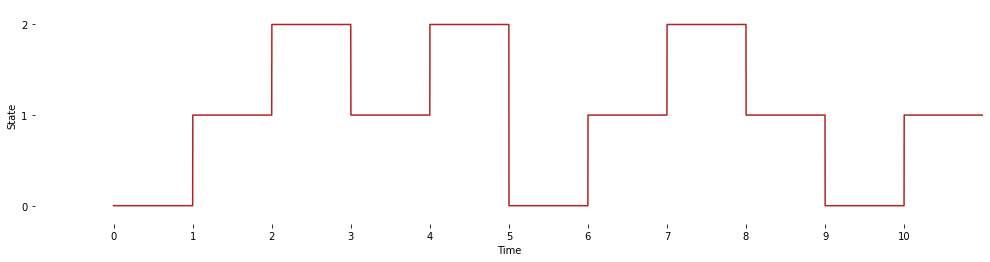

In [14]:
plot_path_step(X)

### Jumping time

Now that we have the path of the routing chain, we need to find the waiting times at each state. Since these change for each state, we will compute these holding times based on the sample path $X$. More precisely the $i+1$th waiting time will be an exponential with rate $\lambda_{X(i)} = - Q(X(i),X(i))$. (The reason why the $i+1$th waiting time corresponds to state $X(i+1)$ is that we take our chain to start at 0.

In [15]:
# the function below computes the waiting times of a continuous Markov chain given
# the path of routing chain and
# the corresponding rate matrix
def wait_times(X, Q):
    T = np.random.exponential(1,len(X))
    for i in range(0,len(X)):
        T[i] = T[i]/-Q[X[i],X[i]]
    return T

Below you can see the times we will spend at each state $X(i)$ before moving on.

In [16]:
T = wait_times(X, Q)
print("Waiting times: \n" + str(T))

Waiting times: 
[0.06104115 0.62629477 0.09510984 0.0308233  0.0157543  0.28977155
 0.77936881 0.16198587 1.62259874 0.09556    0.35253284]


What we actually need are the times at which the jumps happen, i.e. the consecutive sums of the waiting times. Let us compute these now:

In [17]:
# This function computes the jumping times given 
# a sequence of waiting times T

def jump_times(T):
    i = 0
    A = np.zeros(len(T))
    A[0] = T[0]
    for i in range(1, len(T)):
        A[i] = A[i-1] + T[i]
    return(A)

Below you can see the jumping times corresponding to our routing path.

In [18]:
J = jump_times(T)
print("Jumping times: \n" + str(J))

Jumping times: 
[0.06104115 0.68733592 0.78244576 0.81326906 0.82902337 1.11879492
 1.89816373 2.06014959 3.68274833 3.77830833 4.13084117]


Let us now first plot the jump times by themselves: the plot below shows how many jumps will have happened by a certain time, let us call this function $N(t)$.

In [19]:
# This function plots the number of jumps 
# that have happened by a certain time, given
# a sequence oj juming times $J$ (i.e. an increasing sequence)
def plot_jumptimes(T):
    s = int(np.ceil(max(T)))
    # g determines at how many times we evaluate N(t)
    g = s*1000
    # these are the times at which we evaluate N(t)
    x = np.linspace(0, s, g+1)
    x = x[x<=max(T)]
    # y is used to record the number of jumps that happened by time x
    y = np.zeros(len(x))
    for i in range(0,len(x)):
        y[i] = len(T[T<=x[i]])
        
    # now we set up our figure
    plt.figure(figsize=(17, 4))  
    # Remove the plot frame lines.
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)    

    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    #plt.xticks(np.arange(0, s, step=max(1,np.floor(s/20))))

    #Label axes and put in ticks
    plt.ylabel('Number of jumps')
    plt.xlabel('Time')

    ax.plot(x,y, color='deeppink');

Below you can see a plot of the function $N(t)$, that counts the number of jumps that happened by time $t$, for our sample path.

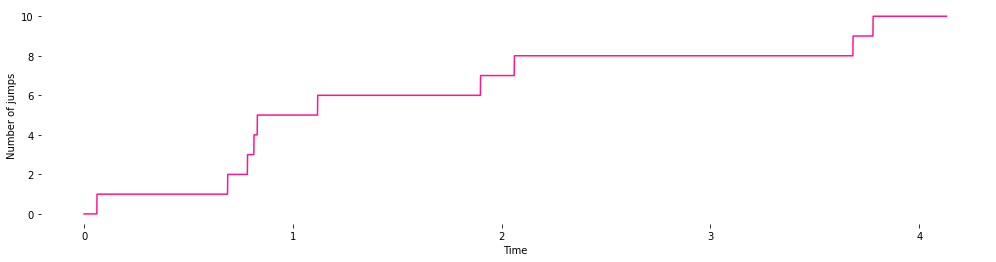

In [20]:
plot_jumptimes(J)

### Putting everything together

Let us finally put all of this together: $N(t)$ gives us the number of jumps that happened by time $t$, thus at time $t$, the continuous chain is at the $N(t)$'th state of the discrete chain $X$. So the continuous chain $Y(t)$ is equal to $X(N(t))$. The following function plots the two ingredients, $X$ and $N$, together with the plot of the continuous Markov chain $Y$.

In [21]:
# This function plots the ingredients 
# of the construction of a continous time Markov chain, given
# a routing path X and
# a corresponding sequence of jump times J.

def plot_construction(X, J):
    
    s = int(np.ceil(max(J)))
    # g determines at how many times we evaluate N(t)
    g = s*1000
    # these are the times at which we evaluate N(t)
    x = np.linspace(0, s, g+1)
    x = x[x<=max(J)]
    # y is used to record the number of jumps that happened by time x
    y = np.zeros(len(x))
    for i in range(0,len(x)):
        y[i] = int(len(J[J<=x[i]]))
        
    Y = np.zeros(len(x))
    for i in range(0,len(x)):
        Y[i] = X[int(y[i])]
    
    # create the figure we will add the plots to
    plt.figure(figsize=(17, 9))
    
    #subplot spacing
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    
    # Remove the plot frame lines.
    ax = plt.subplot(3,1,1)  
    ax.spines["top"].set_visible(True)    
    ax.spines["bottom"].set_visible(True)    
    ax.spines["right"].set_visible(True)    
    ax.spines["left"].set_visible(True) 

    s = len(X)
    # g determines at how many times we evaluate X(t)
    g = s*1000
    # these are the times at which we evaluate X(t)
    z = np.linspace(0, s, g+1, endpoint = False)
    # Z is used to record the continuous version of the discrete chain,
    # i.e. the version that stays in each state for one time unit
    Z = np.zeros(len(z))
    for i in range(0,len(z)):
        Z[i] = X[int(np.floor(z[i]))]  

    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    #Label axes and put in ticks
    plt.ylabel('State')
    plt.xlabel('Discrete time')
    plt.axis([-1, len(X), -0.2, max(X)+0.2])
    plt.xticks(np.arange(0, len(X), step=max(1,np.floor(len(X)/20))));
    plt.yticks(np.arange(0, max(X)+1, step = 1));    
    
    # Choose style of the lines
    ax.plot(z, Z, linestyle = 'solid', color = 'firebrick')
    
    ax = plt.subplot(3,1,2)  
    #Label axes and put in ticks
    plt.ylabel('Number of jumps')
    plt.xlabel('Continuous time')
    ax.plot(x, y, linestyle = 'solid', color = 'deeppink')
    
    ax = plt.subplot(3,1,3) 
    #Label axes and put in ticks
    plt.ylabel('State')
    plt.xlabel('Continuous time')
    plt.yticks(np.arange(0, max(Y)+1, step = 1));  
    ax.plot(x,Y, linestyle = 'solid', color = 'darkcyan')

Below you can see the three plots next to each other. It should be visible that the continuous time chain follows the same path as the discrete chain but the moves to a different state happen according to the times from the jump times. In other words, the path of the continuous time Markov chain is generated by extending and shortening the waiting times at each state according to exponential waiting times.

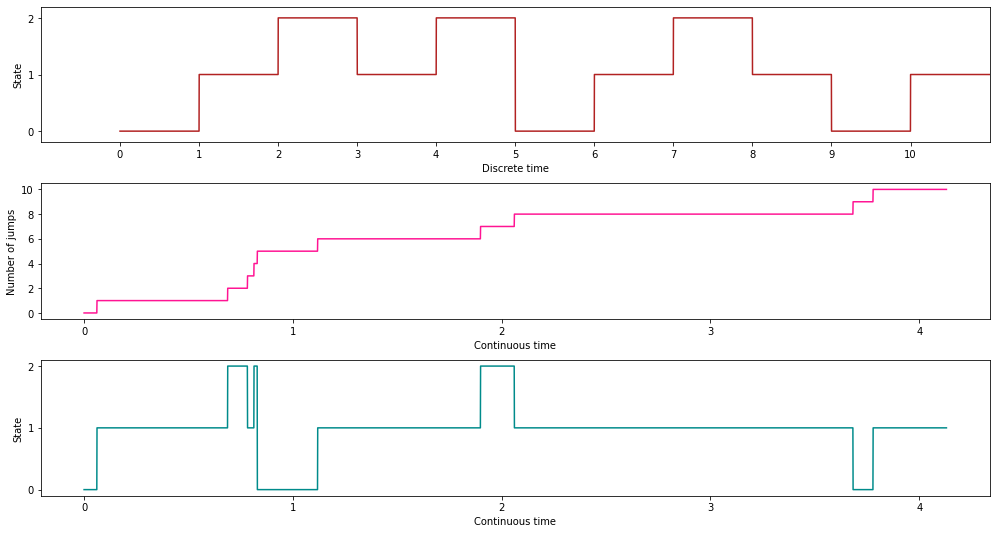

In [22]:
plot_construction(X,J)

In the matrix $Q$ that we defined, the rate at which we leave 1 is much lower than the rates at which we leave states 0 or 2. This should be visible in the plots: the longer waiting times should tend to correspond to times at which the chain is in state 1. 

**Question 1:** Are there any other interesting observations that can be made?

### Explore

Below you can look at the output for different rate matrices $Q$ and number of jumps $steps$. Below we define a function that does the construction all at once and then plots the discrete path, the waiting times, and the continuous time Markov chain. Feel free to change the rates of the matrix $Q$, but make sure to not create a row with 0's only, because the program does not work for chains with absorbant states.

In [23]:
# rate of moving from 0 to 1
q_01 = 2
# rate of moving from 0 to 2
q_02 = 1
# rate of moving from 1 to 0
q_10 = 1
# rate of moving from 1 to 2
q_12 = 1
# rate of moving from 2 to 0
q_20 = 0.5
# rate of moving from 2 to 1
q_21 = 0.1

Q = np.array([[- q_01 - q_02, q_01, q_02], [q_10, -q_10 - q_12, q_12], [q_20, q_21, -q_20 - q_21]])

# we round the matrix to avoid floating point errors
Q = np.round(Q,10)

print("Q = \n", Q)

Q = 
 [[-3.   2.   1. ]
 [ 1.  -2.   1. ]
 [ 0.5  0.1 -0.6]]


In [24]:
# The function below plots the path 
# of a continuous matrix with 
# rate matrix: Q, 
# starting state: start and 
# number of state switches: nsteps.
def plot_cont_path(Q, start, nsteps):
    
    # first we check whether we have a valid rate matrix
    check_rate_mat(Q)
    
    # second we check whether start is a valid state of this Markov chain
    if start not in range(0,np.shape(Q)[1]):
        print("This is not a valid starting point.")
        return
    
    # create the routing matrix
    R = route_from_rate(Q)
    check_trans(R)
    
    # we will use this to save the discrete routing chain
    X = np.zeros(nsteps+1)
    # starting state
    X[0] = start
    for i in range(0, nsteps) :
        step = uniform.rvs(size = 1, loc = 0, scale = 1)
        next = 0
        while sum(R[int(X[i])][range(0,next+1)]) < step:
                  next = next + 1
        X[i+1] = next
        
    X = X.astype(int)
    
    # now we compute the step version of X
    s = len(X)
    # g determines at how many times we evaluate X(t)
    g = s*1000
    # these are the times at which we evaluate X(t)
    z = np.linspace(0, s, g+1, endpoint = False)
    # Z is used to record the continuous version of the discrete chain,
    # i.e. the version that stays in each state for one time unit
    Z = np.zeros(len(z))
    for i in range(0,len(z)):
        Z[i] = X[int(np.floor(z[i]))]  
    
    # now we search for the waiting times
    T = wait_times(X, Q)
    
    # and convert it to the jump times
    J = jump_times(T)
    
    # now we compute the value of the continuous chain
    s = int(np.ceil(max(J)))
    # g determines at how many times we evaluate N(t)
    g = s*1000
    # these are the times at which we evaluate N(t)
    x = np.linspace(0, s, g+1)
    x = x[x<=max(J)]
    # y is used to record the number of jumps that happened by time x
    y = np.zeros(len(x))
    for i in range(0,len(x)):
        y[i] = int(len(J[J<=x[i]]))
        
    Y = np.zeros(len(x))
    for i in range(0,len(x)):
        Y[i] = X[int(y[i])]
    
    # create the figure we will add the plots to
    plt.figure(figsize=(17, 9))
    
    #subplot spacing
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    
    # plot frame lines.
    ax = plt.subplot(3,1,1)  
    ax.spines["top"].set_visible(True)    
    ax.spines["bottom"].set_visible(True)    
    ax.spines["right"].set_visible(True)    
    ax.spines["left"].set_visible(True) 
    
    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    #Label axes and put in ticks
    plt.ylabel('State')
    plt.xlabel('Discrete time')
    plt.axis([-1, len(X), -0.2, max(X)+0.2])
    plt.xticks(np.arange(0, len(X), step=max(1,np.floor(len(X)/20))));
    plt.yticks(np.arange(0, max(X)+1, step = 1));    
    
    # Choose style of the lines
    ax.plot(z, Z, linestyle = 'solid', color = 'firebrick')
    
    ax = plt.subplot(3,1,2)  
    #Label axes and put in ticks
    plt.ylabel('Number of jumps')
    plt.xlabel('Continuous time')
    ax.plot(x, y, linestyle = 'solid', color = 'deeppink')
    
    ax = plt.subplot(3,1,3) 
    #Label axes and put in ticks
    plt.ylabel('State')
    plt.xlabel('Continuous time')
    plt.yticks(np.arange(0, max(Y)+1, step = 1));  
    ax.plot(x, Y, linestyle = 'solid', color = 'darkcyan')
    
    

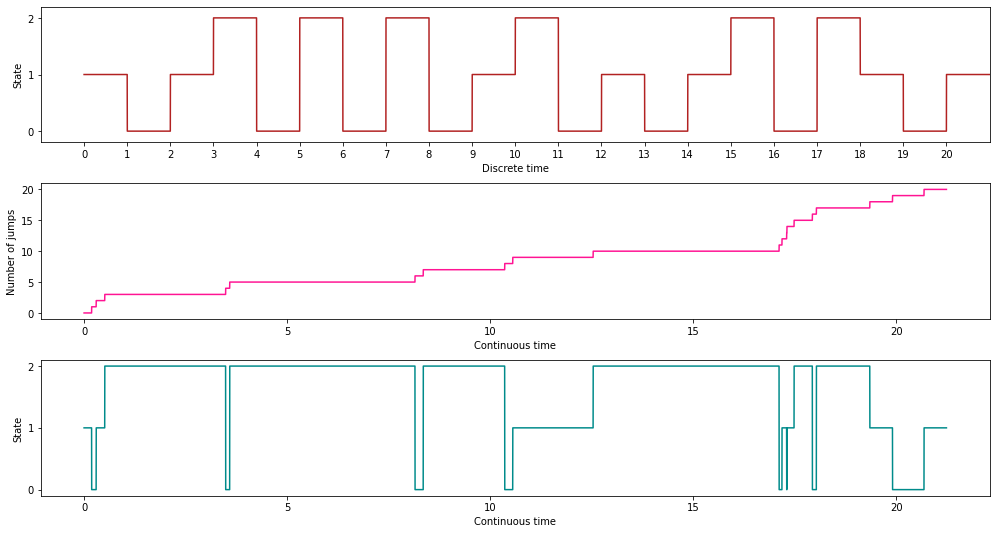

In [25]:
# starting state of the Markov chain
start = 1
# number of jumps the matrix makes
steps = 20

plot_cont_path(Q, start, steps)

**Question 2:** Did your exploration lead to any observations? Some things you can try are to make all the rates equal, or to make the rates very different from each other. You can also look at the output for different rate matrices that have the same routing matrix.

Congrats on finishing the sixth notebook! I hope that it was interesting and I'd be happy about any __[feedback](https://docs.google.com/forms/d/e/1FAIpQLSe42BjDteeuBn_V4ABxSeQGid6ZzoEuydFmI7OvO2R1ap9T3g/viewform?usp=sf_link)__.